## Creating Custom Networks
In this notebook you have to create a custom network whose architecture has been given, and use the dataset you created earlier to train and test it.

In [1]:
# Import Statements
#
# Several of the imports you will need have been added but you will need to provide the
# rest yourself; you should be able to figure out most of the imports as you go through
# the notebook since without proper imports your code will fail to run
#
# All import statements go in this block

from __future__ import division, print_function, unicode_literals
import sys
sys.path.append('/home/tulsyan/apps/miniconda2/lib/python2.7/site-packages/')
sys.path.append('/home/tulsyan/apps/miniconda2/lib/python2.7/site-packages/torchvision-0.1.9-py2.7.egg')
# print(sys.path)

import numpy as np
import torch
import torch.nn as nn
import torch.utils.data
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn.functional as tnf
from torch.autograd import Variable
from torchvision import datasets

%matplotlib inline
import matplotlib.pyplot as plt

All hyper parameters go in the next block

In [2]:
use_gpu = True and torch.cuda.is_available()

batch_size = 100
num_epochs = 5
learning_rate = 0.0005
# 5, 0.001: 92%
# 5, 0.005: 92%
# 5, 0.01 : 91%
# 5, 0.05 : 88%
# 5, 0.1  : 10%
# 5, 0.5  : 10%
# 10, 0.0002: 92%
# 10, 0.0005: 92%
# 10, 0.001: 92%
# 10, 0.005: 91%
# 10, 0.01 : 91%
# 10, 0.05 : 89%
# 10, 0.1  : 86%
# 10, 0.5  : 10%
# 20, 0.0005: 91%
# 20, 0.001: 89%
# 20, 0.005: 91%
# 20, 0.01 : 90%
# 20, 0.05 : 89%
# 20, 0.1  : 10%
# 50, 0.0005: 91%
# 50, 0.001: 90%
# 50, 0.005: 88%
# 50, 0.01 : 90%
# 50, 0.05 : 89%
# 50, 0.1  : 84%
# 50, 0.5  : 10%
# 100,0.0005: 91%

### Create Custom Dataset and Loader
This is the same as part 1. Simply use the same code to create the dataset.

In [3]:
class CDATA(torch.utils.data.Dataset):
    # Copy the code from part 1
    def __init__(self, root_dir, train, transform=None):
        # root_dir  - the root directory of the dataset
        # train     - a boolean parameter representing whether to return the training set or the test set
        # transform - the transforms to be applied on the images before returning them
        #
        # In this function store the parameters in instance variables and make a mapping
        # from images to labels and keep it as an instance variable. Make sure to check which
        # dataset is required; train or test; and create the mapping accordingly.
        self.root_dir = root_dir
        self.train = train
        self.transform = transform
        if train:
            root_dir += 'train/'
        else:
            root_dir += 'test/'
        self.imagefolder_dataset = datasets.ImageFolder(root=root_dir,
                                                       transform=transform)
        
    def __len__(self):
        # return the size of the dataset (total number of images) as an integer
        # this should be rather easy if you created a mapping in __init__
        
        return self.imagefolder_dataset.__len__()
        
    def __getitem__(self, idx):
        # idx - the index of the sample requested
        #
        # Open the image correspoding to idx, apply transforms on it and return a tuple (image, label)
        # where label is an integer from 0-9 (since notMNIST has 10 classes)
        image, label = self.imagefolder_dataset.__getitem__(idx)
        return (image, label)
    
composed_transform = transforms.Compose([transforms.Scale((32,32)),transforms.ToTensor()])
train_dataset = CDATA(root_dir='../custom_dataset/', train=True, transform=composed_transform) # Supply proper root_dir
test_dataset = CDATA(root_dir='../custom_dataset/', train=False, transform=composed_transform) # Supply proper root_dir

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

### Creating a Custom Network
It's time to create a new custom network. This network is based on Resnet (indeed it is a resnet since it uses skip connections). The architecture of the network is provided in the diagram. It specifies the layer names, layer types as well as their parameters.
<img src="../architecture/architecture.png" width=100>
[Full size image](../architecture/architecture.html)

In [4]:
class CustomResnet(nn.Module): # Extend PyTorch's Module class
    def __init__(self, num_classes = 10):
        super(CustomResnet, self).__init__() # Must call super __init__()
        
        # Define the layers of the network here
        # There should be 17 total layers as evident from the diagram
        # The parameters and names for the layers are provided in the diagram
        # The variable names have to be the same as the ones in the diagram
        # Otherwise, the weights will not load
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=True)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.lyr1conv1 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=True)
        self.lyr1bn1 = nn.BatchNorm2d(64)
        self.lyr1relu1 = nn.ReLU(inplace=True)
        self.lyr1conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=True)
        self.lyr1bn2 = nn.BatchNorm2d(64)
        self.lyr1relu2 = nn.ReLU(inplace=True)
        self.lyr2conv1 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=True)
        self.lyr2bn1 = nn.BatchNorm2d(64)
        self.lyr2relu1 = nn.ReLU(inplace=True)
        self.lyr2conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=True)
        self.lyr2bn2 = nn.BatchNorm2d(64)
        self.lyr2relu2 = nn.ReLU(inplace=True)
        self.fc = nn.Linear(4096, num_classes)
        
    def forward(self, x):
        # Here you have to define the forward pass
        # Make sure you take care of the skip connections
        # print(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x1 = self.lyr1conv1(x)
        x1 = self.lyr1bn1(x1)
        x1 = self.lyr1relu1(x1)
        x1 = self.lyr1conv2(x1)
        x1 = self.lyr1bn2(x1)
        x1 = self.lyr1relu2(x+x1)
        x = self.lyr2conv1(x1)
        x = self.lyr2bn1(x)
        x = self.lyr2relu1(x)
        x = self.lyr2conv2(x)
        x = self.lyr2bn2(x)
        x = self.lyr2relu2(x+x1)
        x = self.fc(x.view(x.size(0), -1))
        return x;

#### Finetune on pre-trained CIFAR-100 weights
We shall now finetune our model using pretrained CIFAR-100 weights.

In [7]:
model = CustomResnet(num_classes=100) # 100 classes since CIFAR-100 has 100 classes

# Load CIFAR-100 weights. (Download them from assignment page)
# If network was properly implemented, weights should load without any problems
model.load_state_dict(torch.load('../CIFAR-100_weights')) # Supply the path to the weight file

if use_gpu:
    model.cuda()

##### Optional
As a sanity check you may load the CIFAR-100 test dataset and test the above model. You should get an accuracy of ~41%. This part is optional and is meant for your convenience.

In [9]:
# Block for optionally running the model on CIFAR-100 test set
ctest_dataset = datasets.CIFAR100(root='../cifar_dataset', 
                            train=False, 
                            transform=transforms.ToTensor(),  
                            download=True)

# Data Loader (Input Pipeline)
ctest_loader = torch.utils.data.DataLoader(dataset=ctest_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=True)

def ctest():
    # Write loops for testing the model on the test set
    # You should also print out the accuracy of the model
    correct = 0
    total = 0
    
    for images, labels in ctest_loader:
        images = Variable(images)
        
        if (use_gpu):
            images = images.cuda()
            
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.cpu() == labels.cpu()).sum()
    print('Accuracy of the network on the %d test images: %d %%' % (total, 100 * correct / total))

    
%time ctest()

Files already downloaded and verified
Accuracy of the network on the 10000 test images: 41 %
CPU times: user 2.04 s, sys: 286 ms, total: 2.33 s
Wall time: 2.32 s


Let's finetune the model.

Epoch [1/5], Step [100/168], Loss: 0.2194
Epoch [2/5], Step [100/168], Loss: 0.1169
Epoch [3/5], Step [100/168], Loss: 0.2301
Epoch [4/5], Step [100/168], Loss: 0.1944
Epoch [5/5], Step [100/168], Loss: 0.1318


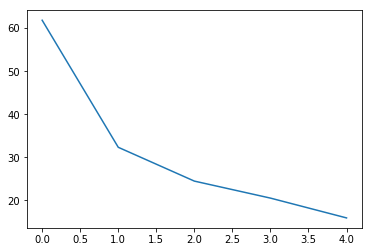

CPU times: user 1min 33s, sys: 18.5 s, total: 1min 51s
Wall time: 1min 51s
Accuracy of the network on the 1870 test images: 91 %
CPU times: user 923 ms, sys: 245 ms, total: 1.17 s
Wall time: 1.07 s


In [31]:
# Change last layer to output 10 classes since our dataset has 10 classes
# Complete this statement. It is similar to the resnet18 case
model.fc = nn.Linear(model.fc.in_features, 10)
if use_gpu and torch.cuda.is_available():
    model.cuda()

# Loss function and optimizers
# Define cross-entropy loss
criterion = nn.CrossEntropyLoss()
# Use Adam optimizer, use learning_rate hyper parameter
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

def train():
    # Code for training the model
    # Make sure to output a matplotlib graph of training losses
    loss_store = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            # Convert torch tensor to Variable
            images = Variable(images)
            labels = Variable(labels)
            if (use_gpu):
                images = images.cuda()
                labels = labels.cuda()
            # Forward + Backward + Optimize
            optimizer.zero_grad()  # zero the gradient buffer
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()    
            
            running_loss += loss.data[0]
            
            if (i+1)%100 == 0:
                print ('Epoch [%d/%d], Step [%d/%d], Loss: %.4f' 
                       %(epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.data[0]))
        loss_store += [running_loss]

    plt.plot(loss_store)
    plt.show()

%time train()
%time test()

# Test the finetuned model

In [8]:
def test():
    # Write loops for testing the model on the test set
    # You should also print out the accuracy of the model
    correct = 0
    total = 0
    
    for i, (images, labels) in enumerate(test_loader):
        images = Variable(images)
        
        if (use_gpu):
            images = images.cuda()
            
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.cpu() == labels.cpu()).sum()
    print('Accuracy of the network on the %d test images: %d %%' % (total, 100 * correct / total))
    
%time test()

Accuracy of the network on the 1870 test images: 91 %
CPU times: user 943 ms, sys: 145 ms, total: 1.09 s
Wall time: 1.1 s


#### Training from scratch
Now we shall try training the model from scratch and observe the differences.

In [ ]:
# Reinstantiate the model and optimizer
model = CustomResnet(num_classes = 10)
# Use Adam optimizer, use learning_rate hyper parameter
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train
%time train()

# Test
%time test()

This is the end of Assignment 1